# import 

In [1]:
import os
import sys 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

import torch
from torch import nn 
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score


from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.tab_model import TabNetClassifier

import lightgbm as lgb

from utils.util import seed_everything

In [10]:
INPUT_PATH = '/working/input'
OUTPUT_PATH = '/working/ouput'

train = pd.read_csv(os.path.join(INPUT_PATH,'train.csv'))
test = pd.read_csv(os.path.join(INPUT_PATH,'test.csv'))


In [11]:
seed_everything(seed_value=42)

# Preprocess

In [12]:
n_train = len(train)
data = pd.concat([train,test],sort=False).reset_index(drop=True)

In [13]:
data['Sex']=data['Sex'].replace(['male','female'],[0,1])
data['Embarked'] =  data['Embarked'].fillna(('S'))
data['Embarked'] =  data['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
data['Fare'] = data['Fare'].fillna(np.mean(data['Fare']))
data['Age'] = data['Age'].fillna(data['Age'].median())

In [14]:
del_col = ['Name','PassengerId','Ticket','Cabin']
data.drop(del_col, axis=1, inplace=True)

In [15]:
train = data[:n_train].reset_index(drop=True)
test = data[n_train:].reset_index(drop=True)

# Feature cols

In [17]:
feature_col = [col for col in train.columns.tolist() if col != 'Survived']

Define categorical features for categorical embeddings 

In [18]:
feature_col

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [19]:
cate_cols = ['Pclass','Sex','SibSp','Parch','Embarked']

cate_dims = {}

for col in cate_cols:
    cate_dims[col] = train[col].unique()

In [23]:
cat_idxs = [i for i, f in enumerate(feature_col) if f in cate_cols]
cat_dims = [cate_dims[f] for i, f in enumerate(feature_col) if f in cate_cols]

# TabNet Pretraining

In [25]:
tabnet_params = dict(n_d=8, n_a=8, n_steps=3, gamma=1.3,
                     n_independent=2, n_shared=2,
                     seed=42, lambda_sparse=1e-3, 
                     optimizer_fn=torch.optim.Adam, 
                     optimizer_params=dict(lr=2e-2),
                     mask_type="entmax",
                     scheduler_params=dict(mode="min",
                                           patience=5,
                                           min_lr=1e-5,
                                           factor=0.9,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=10
                    )

In [26]:
pretrainer = TabNetPretrainer(**tabnet_params)

pretrainer.fit(
        X_train=train.drop('Survived',axis=1).values,
        eval_set=[train.drop('Survived',axis=1).values],
        max_epochs=200,
        patience=20,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=1,
        drop_last=True
)

Device used : cpu
epoch 0  | loss: 4.22455 | val_0_unsup_loss: 20.43877|  0:00:00s
epoch 10 | loss: 1.69857 | val_0_unsup_loss: 2.50951 |  0:00:04s
epoch 20 | loss: 1.21721 | val_0_unsup_loss: 1.44622 |  0:00:08s
epoch 30 | loss: 0.81575 | val_0_unsup_loss: 1.23545 |  0:00:12s
epoch 40 | loss: 0.92009 | val_0_unsup_loss: 1.19396 |  0:00:16s
epoch 50 | loss: 0.85539 | val_0_unsup_loss: 1.11022 |  0:00:21s
epoch 60 | loss: 0.8575  | val_0_unsup_loss: 1.0535  |  0:00:25s
epoch 70 | loss: 0.87378 | val_0_unsup_loss: 1.02438 |  0:00:29s
epoch 80 | loss: 0.93344 | val_0_unsup_loss: 1.0308  |  0:00:33s
epoch 90 | loss: 0.84047 | val_0_unsup_loss: 0.97811 |  0:00:37s
epoch 100| loss: 0.89844 | val_0_unsup_loss: 0.94757 |  0:00:41s
epoch 110| loss: 0.75359 | val_0_unsup_loss: 0.93703 |  0:00:45s
epoch 120| loss: 0.77009 | val_0_unsup_loss: 0.93611 |  0:00:49s

Early stopping occured at epoch 126 with best_epoch = 106 and best_val_0_unsup_loss = 0.90037
Best weights from best epoch are automatic

# Make Folds

In [28]:
skf = StratifiedKFold(n_splits=5)
for i, (trn_idx, val_idx) in enumerate(skf.split(train.drop('Survived',axis=1), train['Survived'])):
    train.loc[val_idx,'fold'] = int(i)

# Tabnet Training

In [40]:

oof = np.zeros((len(train),))
test_preds_all = np.zeros((len(test),))
models = []

for fold_num in range(5):
    trn_idx = train[train.fold != fold_num].index
    val_idx = train[train.fold == fold_num].index
    print(f"FOLD: {fold_num}")
    
    X_train, y_train = train[feature_col].values[trn_idx],  train['Survived'].values[trn_idx]
    X_valid, y_valid = train[feature_col].values[val_idx], train['Survived'].values[val_idx]
    
    tabnet_params = dict(n_d=8, n_a=8, n_steps=3, gamma=1.3,
                     n_independent=2, n_shared=2,
                     seed=42, lambda_sparse=1e-3,
                     optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2,
                                           weight_decay=1e-5
                                          ),
                     mask_type="entmax",
                     scheduler_params=dict(max_lr=0.05,
                                           steps_per_epoch=int(X_train.shape[0] / 256),
                                           epochs=200,
                                           is_batch_level=True
                                          ),
                     scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
                     verbose=10,
                     cat_idxs=cat_idxs, # comment out when Unsupervised
                     cat_dims=cat_dims, # comment out when Unsupervised
                     cat_emb_dim=1 # comment out when Unsupervised
                    )
    model = TabNetClassifier(**tabnet_params)
    model.fit(X_train=X_train,
              y_train=y_train,
              eval_set=[(X_valid, y_valid)],
              eval_name = ["valid"],
              eval_metric = ["auc"],
              max_epochs=200,
              patience=20, batch_size=256, virtual_batch_size=128,
              num_workers=0, drop_last=False,
              from_unsupervised=pretrainer # comment out when Unsupervised
             )
    
    oof[val_idx] = model.predict(X_valid)
    models.append(model)
    pred_test = model.predict(test[feature_col].values)
    test_preds_all += preds_test / 5



FOLD: 0
Device used : cpu
Loading weights from unsupervised pretraining


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_dims changed from [array([3, 1, 2]), array([0, 1]), array([1, 0, 3, 4, 2, 5, 8]), array([0, 1, 2, 5, 3, 4, 6]), array([0, 1, 2])] to []
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_idxs changed from [0, 1, 3, 4, 6] to []
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.85153 | valid_auc: 0.54914 |  0:00:00s
epoch 10 | loss: 0.58294 | valid_auc: 0.59321 |  0:00:01s
epoch 20 | loss: 0.42628 | valid_auc: 0.78202 |  0:00:01s
epoch 30 | loss: 0.37901 | valid_auc: 0.8469  |  0:00:02s
epoch 40 | loss: 0.37052 | valid_auc: 0.84704 |  0:00:03s
epoch 50 | loss: 0.39622 | valid_auc: 0.79183 |  0:00:04s
epoch 60 | loss: 0.37375 | valid_auc: 0.8473  |  0:00:05s

Early stopping occured at epoch 63 with best_epoch = 43 and best_valid_auc = 0.86535
Best weights from best epoch are automatically used!
FOLD: 1
Device used : cpu
Loading weights from unsupervised pretraining


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_dims changed from [array([3, 1, 2]), array([0, 1]), array([1, 0, 3, 4, 2, 5, 8]), array([0, 1, 2, 5, 3, 4, 6]), array([0, 1, 2])] to []
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_idxs changed from [0, 1, 3, 4, 6] to []
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.8748  | valid_auc: 0.67005 |  0:00:00s
epoch 10 | loss: 0.60845 | valid_auc: 0.71818 |  0:00:01s
epoch 20 | loss: 0.41081 | valid_auc: 0.81444 |  0:00:02s
epoch 30 | loss: 0.361   | valid_auc: 0.79786 |  0:00:03s

Early stopping occured at epoch 39 with best_epoch = 19 and best_valid_auc = 0.82273
Best weights from best epoch are automatically used!
FOLD: 2
Device used : cpu
Loading weights from unsupervised pretraining


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_dims changed from [array([3, 1, 2]), array([0, 1]), array([1, 0, 3, 4, 2, 5, 8]), array([0, 1, 2, 5, 3, 4, 6]), array([0, 1, 2])] to []
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_idxs changed from [0, 1, 3, 4, 6] to []
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.84117 | valid_auc: 0.59051 |  0:00:00s
epoch 10 | loss: 0.6066  | valid_auc: 0.74806 |  0:00:01s
epoch 20 | loss: 0.4238  | valid_auc: 0.826   |  0:00:01s
epoch 30 | loss: 0.40128 | valid_auc: 0.81544 |  0:00:02s
epoch 40 | loss: 0.38532 | valid_auc: 0.8377  |  0:00:03s
epoch 50 | loss: 0.37821 | valid_auc: 0.826   |  0:00:04s
epoch 60 | loss: 0.3547  | valid_auc: 0.86745 |  0:00:05s
epoch 70 | loss: 0.34897 | valid_auc: 0.87233 |  0:00:06s
epoch 80 | loss: 0.35658 | valid_auc: 0.85802 |  0:00:06s

Early stopping occured at epoch 82 with best_epoch = 62 and best_valid_auc = 0.88202
Best weights from best epoch are automatically used!
FOLD: 3
Device used : cpu
Loading weights from unsupervised pretraining


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_dims changed from [array([3, 1, 2]), array([0, 1]), array([1, 0, 3, 4, 2, 5, 8]), array([0, 1, 2, 5, 3, 4, 6]), array([0, 1, 2])] to []
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_idxs changed from [0, 1, 3, 4, 6] to []
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.85323 | valid_auc: 0.61705 |  0:00:00s
epoch 10 | loss: 0.61379 | valid_auc: 0.74719 |  0:00:01s
epoch 20 | loss: 0.41736 | valid_auc: 0.83656 |  0:00:02s
epoch 30 | loss: 0.38189 | valid_auc: 0.83676 |  0:00:03s
epoch 40 | loss: 0.39883 | valid_auc: 0.80856 |  0:00:04s

Early stopping occured at epoch 45 with best_epoch = 25 and best_valid_auc = 0.89559
Best weights from best epoch are automatically used!
FOLD: 4
Device used : cpu
Loading weights from unsupervised pretraining


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_dims changed from [array([3, 1, 2]), array([0, 1]), array([1, 0, 3, 4, 2, 5, 8]), array([0, 1, 2, 5, 3, 4, 6]), array([0, 1, 2])] to []
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_idxs changed from [0, 1, 3, 4, 6] to []
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.86898 | valid_auc: 0.60231 |  0:00:00s
epoch 10 | loss: 0.62353 | valid_auc: 0.76645 |  0:00:01s
epoch 20 | loss: 0.45364 | valid_auc: 0.86757 |  0:00:02s
epoch 30 | loss: 0.39923 | valid_auc: 0.89602 |  0:00:02s
epoch 40 | loss: 0.38689 | valid_auc: 0.88592 |  0:00:03s
epoch 50 | loss: 0.3777  | valid_auc: 0.86451 |  0:00:04s
epoch 60 | loss: 0.38406 | valid_auc: 0.88313 |  0:00:05s

Early stopping occured at epoch 66 with best_epoch = 46 and best_valid_auc = 0.90467
Best weights from best epoch are automatically used!


# Metric

In [47]:
print('ROC-AUC')
print(roc_auc_score(train['Survived'].ravel(), oof.ravel()))
print('Accuracy')
print(accuracy_score(train['Survived'].ravel(), (oof >0.5).astype('int').ravel()))
print('ROC-AUC test')

ROC-AUC
0.781564567155594
Accuracy
0.813692480359147
ROC-AUC test
Accuracy test
0.813692480359147


# Global Explainability: feature importance

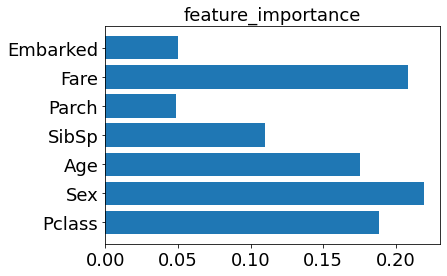

In [53]:
for fold_num, model in enumerate(models):
    # Feature Importance
    feat_imp_fold = pd.DataFrame(model.feature_importances_,index=feature_col, columns= [f'imp_{fold_num}'])
    if fold_num == 0:
        feature_importance = feat_imp_fold.copy()
    else:
        feature_importance = pd.concat([feature_importance, feat_imp_fold], axis=1)
        

feature_importance['imp_mean'] = feature_importance.mean(axis=1)
plt.tick_params(labelsize=18)
plt.barh(feature_importance.index.values,feature_importance['imp_mean']);
plt.title('feature_importance',fontsize=18);

In [54]:
feature_importance

,imp_0,imp_1,imp_2,imp_3,imp_4,imp_mean
Pclass,0.166779,0.205544,0.221500,0.186626,0.160964,0.188283
Sex,0.205414,0.163410,0.250233,0.199747,0.278334,0.219428
Age,0.112469,0.153309,0.218014,0.207240,0.186780,0.175562
SibSp,0.082567,0.097046,0.096862,0.148652,0.125677,0.110161
Parch,0.081826,0.035052,0.052029,0.028617,0.046823,0.048869
Fare,0.204957,0.284996,0.131835,0.219287,0.198966,0.208008
Embarked,0.145988,0.060644,0.029527,0.009831,0.002457,0.049689


# Local explainability and masks

In [57]:
explain_matrix, masks = model.explain(test[feature_col].values)

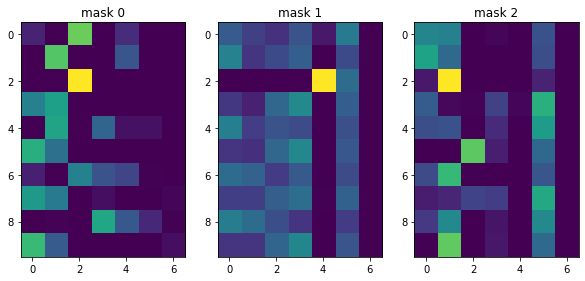

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(10,7))

for i in range(3):
    axs[i].imshow(masks[i][:10])
    axs[i].set_title(f"mask {i}")
